In [27]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
setwd("~/dev/CCRItask")

In [28]:
# map GSM ids to info
files <- list(
  "GSM4446535" = "week8_001",
  "GSM4446536" = "week9_063",
  "GSM4446537" = "week6_088",
  "GSM4446538" = "week14_123",
  "GSM4446539" = "week12_124",
  "GSM4446540" = "week8_125",
  "GSM4446541" = "week9_005",
  "GSM4446542" = "week11_006",
  "GSM4446543" = "week9_007",
  "GSM4734601" = "week8_016",
  "GSM4734602" = "week9_031_paraganglia",
  "GSM4734603" = "week12_035",
  "GSM4734604" = "week12_036_extraadrenal"
)

In [29]:
# List all H5 files in the raw data directory
h5_files <- list.files("data/raw/GSE147821_RAW", pattern = ".h5$", full.names = TRUE)
h5_files

[1] "data/raw/GSE147821_RAW/GSM4446535_10X_19_001.raw_feature_bc_matrix.h5"
 [2] "data/raw/GSE147821_RAW/GSM4446536_10X_19_063.raw_feature_bc_matrix.h5"
 [3] "data/raw/GSE147821_RAW/GSM4446537_10X_19_088.raw_feature_bc_matrix.h5"
 [4] "data/raw/GSE147821_RAW/GSM4446538_10X_19_123.raw_feature_bc_matrix.h5"
 [5] "data/raw/GSE147821_RAW/GSM4446539_10X_19_124.raw_feature_bc_matrix.h5"
 [6] "data/raw/GSE147821_RAW/GSM4446540_10X_19_125.raw_feature_bc_matrix.h5"
 [7] "data/raw/GSE147821_RAW/GSM4446541_10X_20_005.raw_feature_bc_matrix.h5"
 [8] "data/raw/GSE147821_RAW/GSM4446542_10X_20_006.raw_feature_bc_matrix.h5"
 [9] "data/raw/GSE147821_RAW/GSM4446543_10X_20_007.raw_feature_bc_matrix.h5"
[10] "data/raw/GSE147821_RAW/GSM4734601_10X_20_016.raw_feature_bc_matrix.h5"
[11] "data/raw/GSE147821_RAW/GSM4734602_10X_20_031.raw_feature_bc_matrix.h5"
[12] "data/raw/GSE147821_RAW/GSM4734603_10X_20_035.raw_feature_bc_matrix.h5"
[13] "data/raw/GSE147821_RAW/GSM4734604_10X_20_036.raw_feature_bc_matrix.h5"

In [30]:
names(h5_files) <- sub("_10X_.*", "", basename(h5_files))
h5_files

GSM4446535 
"data/raw/GSE147821_RAW/GSM4446535_10X_19_001.raw_feature_bc_matrix.h5" 
                                                             GSM4446536 
"data/raw/GSE147821_RAW/GSM4446536_10X_19_063.raw_feature_bc_matrix.h5" 
                                                             GSM4446537 
"data/raw/GSE147821_RAW/GSM4446537_10X_19_088.raw_feature_bc_matrix.h5" 
                                                             GSM4446538 
"data/raw/GSE147821_RAW/GSM4446538_10X_19_123.raw_feature_bc_matrix.h5" 
                                                             GSM4446539 
"data/raw/GSE147821_RAW/GSM4446539_10X_19_124.raw_feature_bc_matrix.h5" 
                                                             GSM4446540 
"data/raw/GSE147821_RAW/GSM4446540_10X_19_125.raw_feature_bc_matrix.h5" 
                                                             GSM4446541 
"data/raw/GSE147821_RAW/GSM4446541_10X_20_005.raw_feature_bc_matrix.h5" 
                                                             GSM4446542 
"data/raw/GSE147821_RAW/GSM4446542_10X_20_006.raw_feature_bc_matrix.h5" 
                                                             GSM4446543 
"data/raw/GSE147821_RAW/GSM4446543_10X_20_007.raw_feature_bc_matrix.h5" 
                                                             GSM4734601 
"data/raw/GSE147821_RAW/GSM4734601_10X_20_016.raw_feature_bc_matrix.h5" 
                                                             GSM4734602 
"data/raw/GSE147821_RAW/GSM4734602_10X_20_031.raw_feature_bc_matrix.h5" 
                                                             GSM4734603 
"data/raw/GSE147821_RAW/GSM4734603_10X_20_035.raw_feature_bc_matrix.h5" 
                                                             GSM4734604 
"data/raw/GSE147821_RAW/GSM4734604_10X_20_036.raw_feature_bc_matrix.h5"

## Load each sample into a list of Seurat objects and apply filtering

In [31]:
# Load each sample into a list of Seurat objects
# 3. Process each sample
seurat_list <- lapply(names(files), function(gsm_id) {

  # Get sample info
  sample_name <- files[[gsm_id]]
  week <- as.numeric(sub("week(\\d+).*", "\\1", sample_name))
  sample_id <- sub(".*_(\\d+).*", "\\1", sample_name)
  # Read data
  counts <- Read10X_h5(h5_files[[gsm_id]])
  # Create Seurat object
  seurat_obj <- CreateSeuratObject(
    counts = counts,
    project = sample_name,
    min.cells = 3,
    min.features = 200
  )
  seurat_obj <- subset(seurat_obj, downsample = ncol(seurat_obj)/4)  # Keep 3rd of the cells
  # Add comprehensive metadata
  seurat_obj$orig.ident <- sample_name
  seurat_obj$sample <- sample_name
  seurat_obj$week <- week
  seurat_obj$sample_id <- sample_id
  seurat_obj$gsm_id <- gsm_id
  seurat_obj$condition <- ifelse(
    grepl("paraganglia|extraadrenal", sample_name),
    "special", "regular"
  )
  # Calculate mitochondrial percentage
  seurat_obj[["percent.mt"]] <- PercentageFeatureSet(
    seurat_obj,
    pattern = "^MT-"
  )


  return(seurat_obj)
})

In [32]:
# Name the list elements
names(seurat_list) <- sapply(seurat_list, function(x) unique(x$sample))

## QC and More Filtering

#### These genes are not to be filtered out

In [33]:
cell_type_markers <- list(
  "SCPs" = c("SOX10", "PLP1", "FOXD3"),
  "Chromaffin cells" = c("ELAVL3", "ELAVL4", "PHOX2B", "TH"),
  "Sympathoblasts" = c("STMN2"),
  "Adrenal gland cortex" = c("NR5A1"),
  "Melanocytes" = c("MITF"),
  "Kidney" = c("PAX2"),
  "Subepicardial and abdominal mesenchyme" = c("PRRX1"),
  "Endothelium" = c("PECAM1", "KDR"),
  "Intermediate mesoderm" = c("GATA4", "HAND2"),
  "Liver" = c("HNF4A", "AHSG"),
  "HSCs" = c("SPINK2", "AZU1"),
  "Immune cells" = c("FCGR1A", "CD163"),
  "Erythroid cells" = c("HBA2", "HBB")
)
markers_unique <- unique(unlist(cell_type_markers))


In [34]:
alist = list()
for (i in 1:length(seurat_list)) {
  setdiff(markers_unique,rownames(seurat_list[[i]]))
  alist <- union(alist,setdiff(markers_unique,rownames(seurat_list[[i]])))
}
to_remove <- unique(alist)

genes_to_conserve <- setdiff(markers_unique,to_remove)
genes_to_conserve

[1] "SOX10"  "PLP1"   "FOXD3"  "ELAVL3" "ELAVL4" "PHOX2B" "TH"     "STMN2" 
 [9] "NR5A1"  "MITF"   "PRRX1"  "PECAM1" "KDR"    "GATA4"  "HAND2"  "SPINK2"
[17] "FCGR1A" "CD163"  "HBA2"   "HBB"

In [35]:
# QC
seurat_list <- lapply(seurat_list, function(x) {
  x[["percent.mt"]] <- PercentageFeatureSet(x, pattern = "^MT-")
  x <- subset(x, subset = nFeature_RNA > 500 & nFeature_RNA < 6000 & percent.mt < 15)
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
  # Extract all unique marker genes from the markers list
  
  # Add them to the variable features
  VariableFeatures(x) <- union(VariableFeatures(x), genes_to_conserve)
  return(x)
})

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts



## Cell Cycle Information

In [36]:
# Add cell cycle correction
s_genes <- cc.genes$s.genes
g2m_genes <- cc.genes$g2m.genes
seurat_list <- lapply(seurat_list, function(x) {
  x <- CellCycleScoring(
    x,
    s.features = s_genes,
    g2m.features = g2m_genes,
    set.ident = FALSE
  )
  x$CC.Difference <- x$S.Score - x$G2M.Score  # for regression
  return(x)
})


Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"
Warning message:
"The following features are not present in 

In [37]:
features <- SelectIntegrationFeatures(object.list = seurat_list)

In [38]:
length(features)

[1] 2000

In [39]:
unique(unlist(cell_type_markers))

[1] "SOX10"  "PLP1"   "FOXD3"  "ELAVL3" "ELAVL4" "PHOX2B" "TH"     "STMN2" 
 [9] "NR5A1"  "MITF"   "PAX2"   "PRRX1"  "PECAM1" "KDR"    "GATA4"  "HAND2" 
[17] "HNF4A"  "AHSG"   "SPINK2" "AZU1"   "FCGR1A" "CD163"  "HBA2"   "HBB"

## Perform Integration

In [40]:
# Select integration anchors
anchors <- FindIntegrationAnchors(
  object.list = seurat_list,
  dims = 1:30,
  anchor.features = union(features, genes_to_conserve),
  normalization.method = "LogNormalize"
)

Warning message in CheckDuplicateCellNames(object.list = object.list):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3362 anchors

Filtering anchors

	Retained 2703 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3696 anchors

Filtering anchors

	Retained 2041 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4385 anchors

Filtering anchors

	Retained 3290 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2558 anchors

Filtering anchors

	Retained 2352 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2717 anchors

Filtering anchors

	Retained 2531 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2772 anchors

Fi

In [ ]:
rm(seurat_list) # to open memory space 

In [42]:
anchors


An AnchorSet object containing 374062 anchors between 13 Seurat objects 
 This can be used as input to IntegrateData.

In [43]:

# Integrate data
integrated <- IntegrateData(
  anchorset = anchors,
  dims = 1:30,
  new.assay.name = "integrated"
)


Merging dataset 10 into 9

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Merging dataset 4 into 8

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Merging dataset 5 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Merging dataset 7 into 9 10

Extracting anchors for merged samples

Finding integration vectors

Warning message:
"Different cells in new layer data than already exists for scale.data"
Finding integration vector weights

Integrating data

Warning message:
"Layer counts isn't present in the assay object; retu

In [44]:
# Switch to integrated assay for downstream analysis
DefaultAssay(integrated) <- "integrated"

## Scale data

### Scaling and regression for cell cycle

In [45]:
integrated <- ScaleData(integrated, vars.to.regress = "CC.Difference",  verbose = FALSE)

## Run PCA

In [46]:
integrated <- RunPCA(integrated)

PC_ 1 
Positive:  HLA-E, EGFL7, IFITM3, IGFBP4, KDR, TMSB4X, FLT1, ELK3, RAMP2, PLVAP 
	   CD93, CYBA, CAVIN2, CALCRL, CDH5, ARHGAP29, TGFBR2, ANXA2, PLPP3, TFPI 
	   ETS1, EMCN, PECAM1, PRCP, ADGRF5, TMEM88, CLDN5, ESAM, CD109, NEAT1 
Negative:  NRCAM, DLK1, CDH2, FDXR, STAR, CADM1, APOA1, PEG3, KCNK3, NR5A1 
	   DHCR24, ALDH1A2, PEG10, NOV, APOE, ASB4, PEBP1, MC2R, PPIF, DPP10 
	   RALYL, INHA, MCF2, CYP11A1, COL15A1, SNCG, CACNB2, MGARP, TBX3, SLC16A9 
PC_ 2 
Positive:  COL1A1, COL3A1, COL1A2, PLAC9, COL5A1, COL12A1, GPC3, COL5A2, ISLR, CDH11 
	   CXCL12, PCOLCE, FBN1, COL6A3, VIM, CALD1, OGN, FZD1, PCDH7, DCN 
	   COL16A1, COL6A1, PDE5A, LRRC17, POSTN, PDGFRA, PRRX1, CD248, SULT1E1, TSHZ2 
Negative:  LAPTM5, ARHGAP18, HLA-B, MAN1A1, CD74, TYROBP, C1QC, MEF2C, SRGN, FYB1 
	   LYVE1, CSF1R, DAB2, MRC1, C1QB, CD163, STAB1, C1QA, FCER1G, CD36 
	   MS4A6A, HCST, PLD4, MS4A7, PTPRE, DOCK8, VSIG4, CD83, GYPC, CYBB 
PC_ 3 
Positive:  NOSTRIN, HSPG2, TIMP3, SQLE, SPARC, GNG11, TSPAN13, MGST

## Run UMAP

In [55]:
integrated <- RunUMAP(integrated, dims = 1:50)

19:30:46 UMAP embedding parameters a = 0.9922 b = 1.112

19:30:46 Read 19803 rows and found 50 numeric columns

19:30:46 Using Annoy for neighbor search, n_neighbors = 30



19:30:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:30:47 Writing NN index file to temp file /var/folders/wl/jrkngsm57b944tj7rtjg12000000gn/T//RtmpMPRhXH/filefb51d021310

19:30:47 Searching Annoy index using 1 thread, search_k = 3000

19:30:49 Annoy recall = 100%

19:30:50 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:30:50 Initializing from normalized Laplacian + noise (using RSpectra)

19:30:51 Commencing optimization for 200 epochs, with 912616 positive edges

19:30:51 Using rng type: pcg

19:30:54 Optimization finished



In [56]:
integrated

An object of class Seurat 
28181 features across 19803 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

## Umap Plot

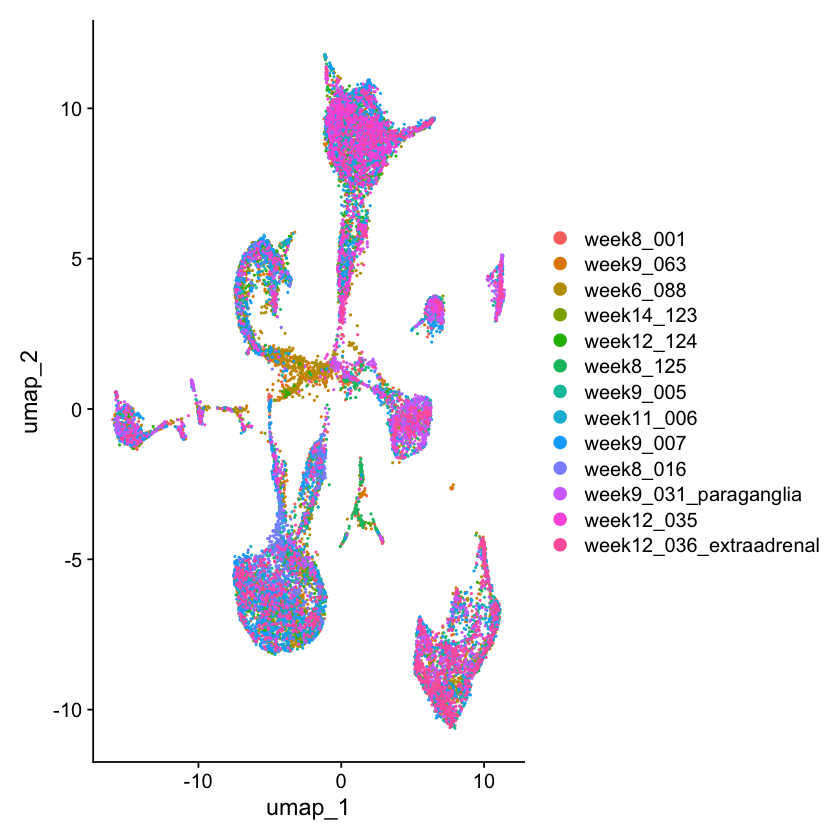

In [50]:
umapfig <- DimPlot(integrated, raster.dpi = c(600,400))
umapfig

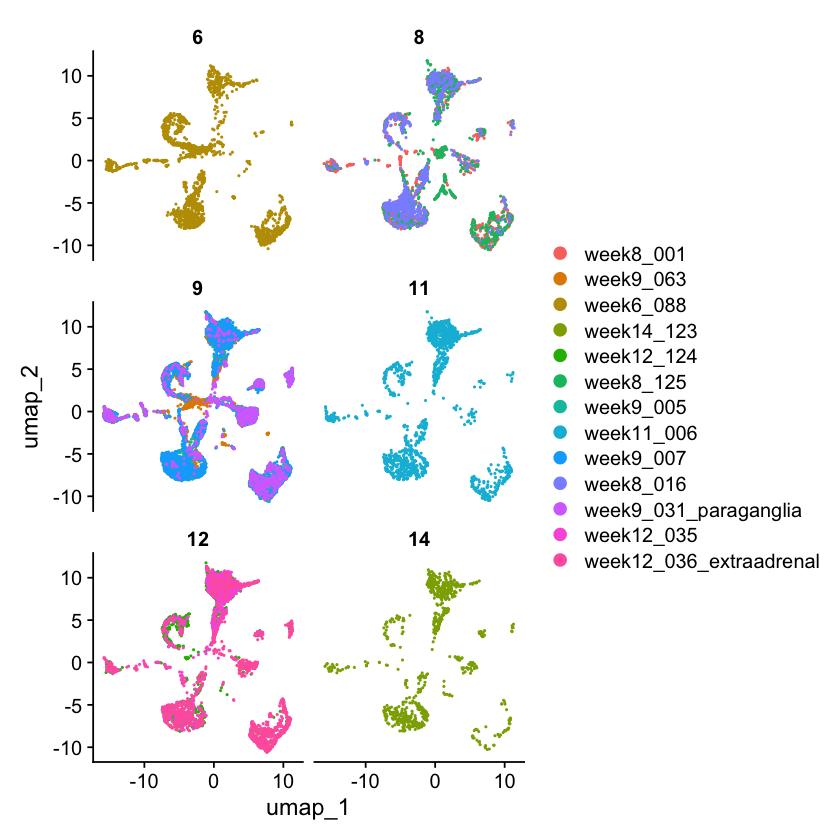

In [59]:
DimPlot(integrated, raster.dpi = c(600,400),split.by = "week", ncol = 2)


In [57]:
saveRDS(integrated, "data/processed/integrated.rds")

In [51]:
library(ggplot2)
ggsave('plots/umap_after_integration.pdf', width = 10, height = 7)

Notes: Integration Succesful